In [1]:
import os
from random import shuffle

import matplotlib.pyplot as plt
import imageio
from skimage.future import graph
from skimage.color import rgb2gray, label2rgb
from skimage.filters import threshold_otsu, difference_of_gaussians
from skimage.segmentation import slic

In [2]:
# To generate dataset.py
def get_images(tiles_dir, amount, random=False):
    images = []
    tiles = os.listdir(tiles_dir)
    if random:
        shuffle(tiles)
    for tile in tiles:
        current_tile = tiles_dir + f"/{tile}/"
        images_path = current_tile + "images/"
        for image_uri in os.listdir(images_path):
            img = imageio.imread(images_path + image_uri)

            images.append(img)
            amount -= 1
            if amount <= 0:
                break
        if amount <= 0:
            break

    return images

In [3]:
def apply_threshold(image):

    grayscale = rgb2gray(image)
    thresh = threshold_otsu(grayscale)
    binary = grayscale > thresh
    log = difference_of_gaussians(grayscale, 5)

    return binary, log

In [12]:
def apply_clustering(image):
    labels1 = slic(image, compactness=30, n_segments=100, start_label=1)
    g = graph.rag_mean_color(image, labels1)
    labels2 = graph.cut_threshold(labels1, g, 29)
    out2 = label2rgb(labels2, image, kind='avg', bg_label=0)
    return labels1, labels2

In [5]:
def apply_semantic_segmentation(image):
    otsu, log = apply_threshold(image)

    k_means, normalized_cut = apply_clustering(image)

    return otsu, log, k_means, normalized_cut

In [9]:
def visualise_semantic(images):
    for semantic in images:
        plt.figure(figsize=(32, 32))

        plt.subplot(141)
        plt.title("Original")
        plt.imshow(semantic[0])

        plt.subplot(142)
        plt.title("Otsu Threshold")
        plt.imshow(semantic[1], cmap=plt.cm.gray)

        # plt.subplot(133)
        # plt.title("Laplacian of Gaussians")
        # plt.imshow(threshold[1], cmap=plt.cm.gray)

        plt.subplot(143)
        plt.title("K-Means")
        plt.imshow(semantic[2], cmap=plt.cm.gray)

        plt.subplot(144)
        plt.title("Mean cut")
        plt.imshow(semantic[3], cmap=plt.cm.gray)
        plt.show()

In [16]:
def segment_images(images):
    semantic_segmentation = []
    for image in images:

        otsu, log, k_means, mean_cut = apply_semantic_segmentation(image)
        # TODO: Design mask between mean_cut segmentation and otsu threshold, to fine tune which regions
        #       are to be semantically marked as buildings.

        semantic_segmentation.append((image, otsu, k_means, mean_cut))
    return semantic_segmentation

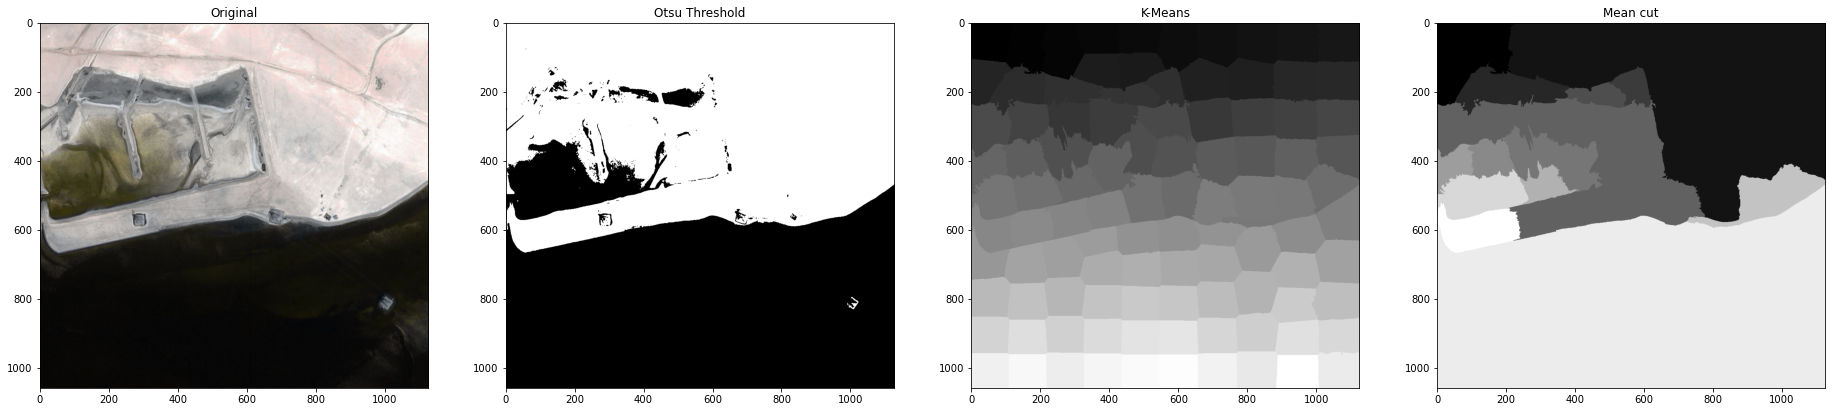

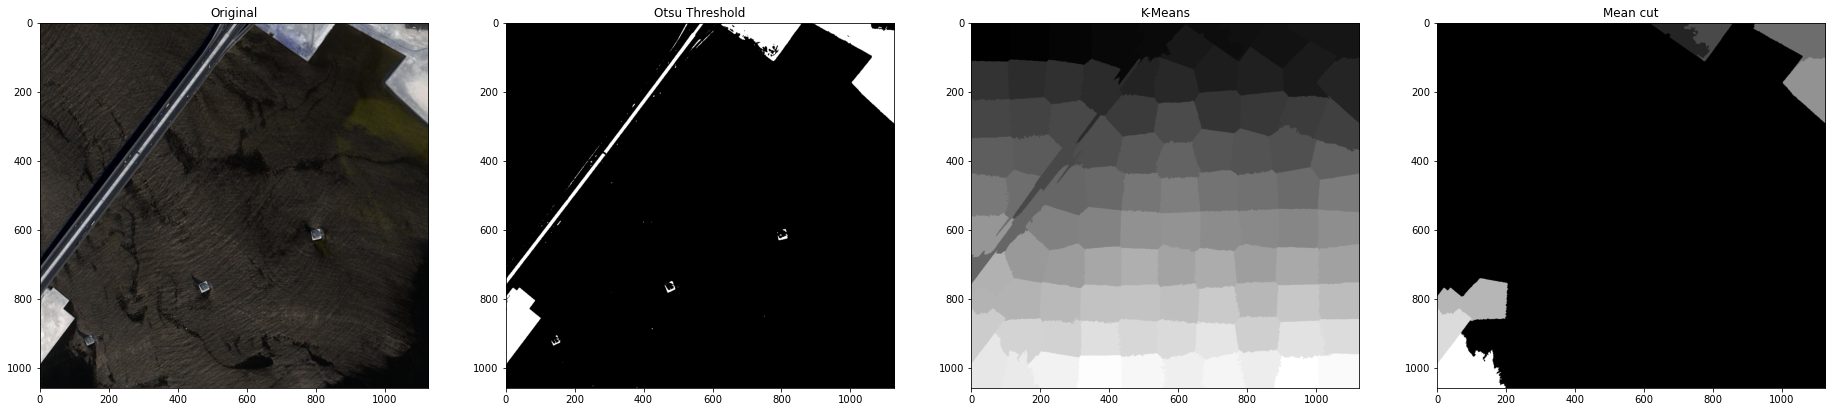

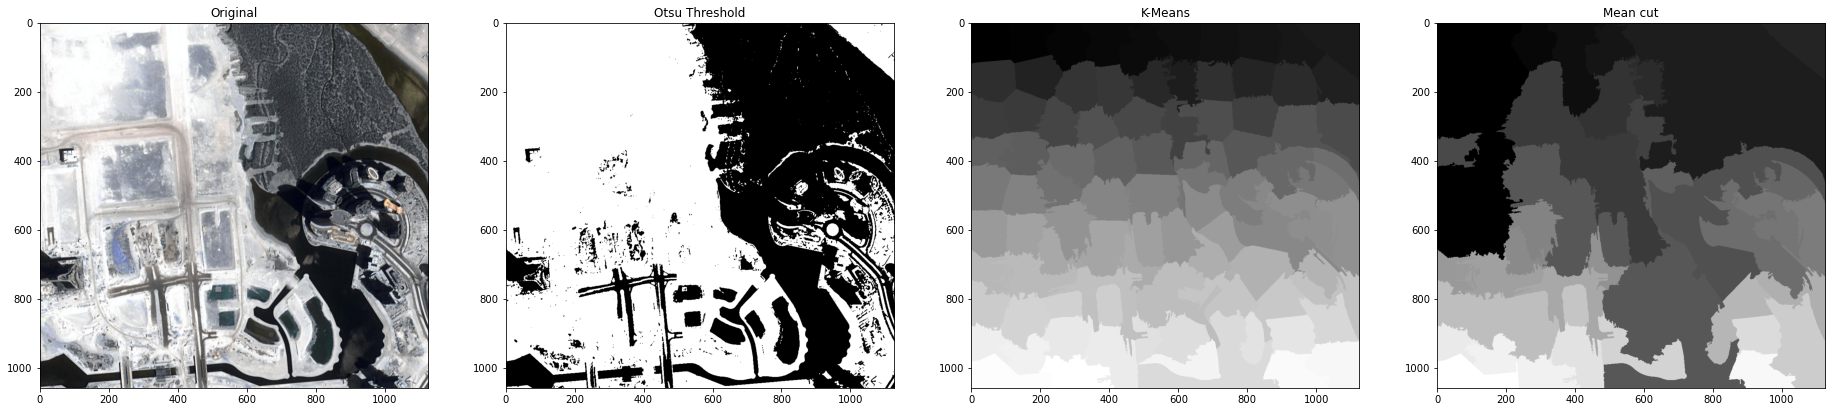

In [17]:
def main():
    images = get_images("data/processed", 3, True)

    semantic_segmentation = segment_images(images)
    visualise_semantic(semantic_segmentation)
if __name__ == "__main__":
    main()